In [1]:
%load_ext autoreload
%autoreload 2

# Tutorial 2: Two-Dimensional Rastrigin

Our goal will be to train a neural network to predict the Rastrigin function, defined as: 

$
f(x_1 \cdots x_n) = 10n + \sum_{i=1}^n \left(x_i^2 -10 \cos(2\pi x_i)\right)
$

In [2]:
import jenn
import matplotlib.pyplot as plt

### Synthetic Data

In a first step, let's define the test function:

In [3]:
test_function = jenn.synthetic.Rastrigin

Next, let's define the domain over which we will collect synthetic training data:

In [4]:
lb = (-1.0, -1.0)
ub = (1.5, 1.5)

We will now generate some synthetic data that will be used to train our GENN model later on:

In [5]:
x_train, y_train, dydx_train = test_function.sample(m_random=100, m_levels=0, lb=lb, ub=ub)

We also generate some synthetic data that will be used to test the accuracy of the trained model:

In [6]:
x_test, y_test, dydx_test = test_function.sample(m_random=0, m_levels=10, lb=lb, ub=ub)

### Training

For comparison, let's train two models: a regular neural network and gradient-enhanced neural network. 

#### Regular Neural Network

In [7]:
%%time 
nn = jenn.model.NeuralNet(
    layer_sizes=[2, 24, 24, 1],
).fit(
    x=x_train, 
    y=y_train, 
    max_iter=10_000, 
    alpha=0.001, 
    lambd=0.0001, 
    is_normalize=True, 
    random_state=123, 
)

CPU times: user 1.92 s, sys: 21.2 ms, total: 1.94 s
Wall time: 1.94 s


#### Gradient-Enhanced Neural Network

In [8]:
%%time 
genn = jenn.model.NeuralNet(
    layer_sizes=[2, 24, 24, 1],
).fit(
    x=x_train, 
    y=y_train,
    dydx=dydx_train,
    max_iter=10_000, 
    alpha=0.001, 
    lambd=0.0001, 
    is_normalize=True, 
    random_state=123, 
)

CPU times: user 3.3 s, sys: 21.9 ms, total: 3.32 s
Wall time: 3.32 s


### Visualization

#### Convergence Histories

It is good practice to check the convergence history in order to decide if we should keep training.

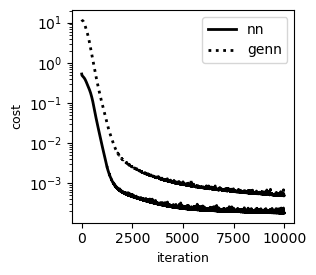

In [9]:
jenn.utils.plot.convergence(histories=[nn.history, genn.history], legend=["nn", "genn"])

#### Goodness of Fit

Upon convergence, let's check how well the model generalizes on test data. All else being equal, GENN generally outperforms NN.

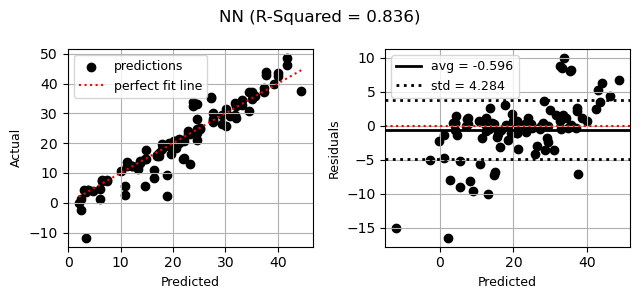

In [10]:
jenn.utils.plot.goodness_of_fit(
    y_true=y_test, 
    y_pred=nn.predict(x_test),
    title="NN"
)

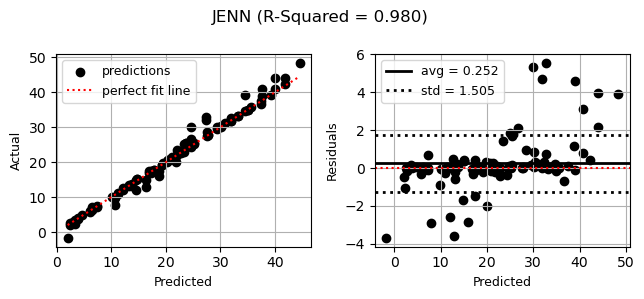

In [11]:
jenn.utils.plot.goodness_of_fit(
    y_true=y_test, 
    y_pred=genn.predict(x_test),
    title="JENN"
)

#### Contour Plots

Since this is a two-dimensional function, we can compare the contour plots of the predicted and true response:

In [12]:
def plot_contours():  
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    figs = [
        jenn.utils.plot.contours(
            func=test_function.evaluate, 
            lb=lb, 
            ub=ub, 
            title="True", 
            ax=ax[0],
            x_train=x_train,
            # x_test=x_test,
            alpha=0.5, 
        ),
        jenn.utils.plot.contours(
            func=genn.predict, 
            lb=lb, 
            ub=ub, 
            title="JENN",  
            ax=ax[1],
        ),
        jenn.utils.plot.contours(
            func=nn.predict, 
            lb=lb, 
            ub=ub, 
            title="NN", 
            ax=ax[2],
        )
    ]
    return fig

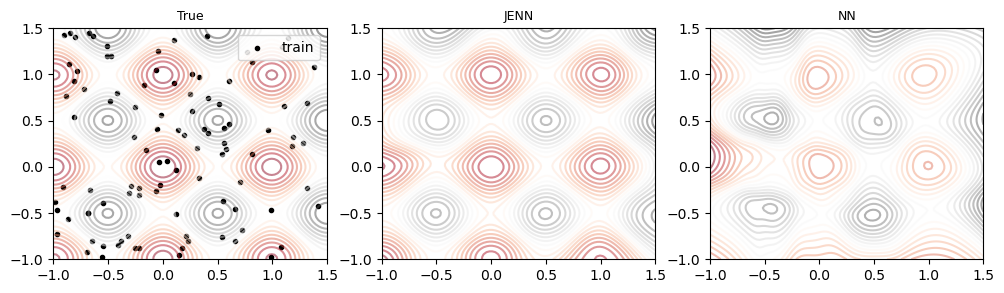

In [13]:
plot_contours()

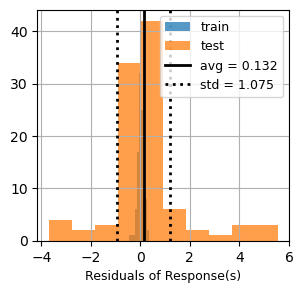

In [19]:
from jenn.post_processing.error_histogram import plot_histogram

plot_histogram(
    y_true=[y_train, y_test], 
    y_pred=[genn.predict(x_train), genn.predict(x_test)], 
    datasets=["train", "test"],
    alpha=0.75, 
    percent=False,
)